In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [3]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [ ]:
df_train.info()

In [ ]:
df_test.info()

In [ ]:
df_test.head(2)

In [ ]:
sample_submission.head(2)

In [ ]:
sample_submission.info()

In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
df.info()

In [5]:
df['reviewer_nationality'].value_counts()

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64

In [6]:
df['hotel_name'].value_counts()

Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
                                                     ... 
Hotel Eitlj rg                                         12
Hotel Daniel Paris                                     12
Mercure Paris Porte d Orleans                          10
Hotel Wagner                                           10
Hotel Gallitzinberg                                     8
Name: hotel_name, Length: 1492, dtype: int64

In [7]:
df['review_date'].value_counts()

8/2/2017      2585
9/15/2016     2308
4/5/2017      2284
8/30/2016     1963
2/16/2016     1940
              ... 
9/10/2016      199
11/27/2015     194
4/3/2017       192
4/1/2017       173
4/2/2017       143
Name: review_date, Length: 731, dtype: int64

**Кодируем  категориальные признаки, количество категорий которых  мало, по сравнению с размером датасета**

In [ ]:
!pip install category_encoders

In [8]:

import category_encoders as ce # импортируем библиотеку для работы с кодировщиками

ord_encoder = ce.OrdinalEncoder()

In [9]:
data_bin = ord_encoder.fit_transform(df[['reviewer_nationality', 'hotel_name','review_date']])          

In [11]:
data_bin.rename(columns={'reviewer_nationality':'rev_national_num', 'hotel_name':'num_hotel_nmae','review_date':'num_review_date'}, inplace=True)

In [12]:
data_bin

,rev_national_num,num_hotel_nmae,num_review_date
0,1,1,1
1,2,2,2
2,3,3,3
3,4,4,4
4,1,5,5
...,...,...,...
515733,17,725,557
515734,34,925,525
515735,6,272,122
515736,20,189,195


In [14]:
df = pd.concat([df, data_bin], axis=1)

In [15]:
df=df.drop(['reviewer_nationality', 'hotel_name','review_date'], axis=1)

**Приводим признак давности отзыва к цифровому значению**

In [18]:
import re
def re_func(days):
    found = re.findall("\d+", days)
    return found
df['days_since_review_1']=df['days_since_review'].apply(re_func).explode()

df['days_since_review_1']=pd.to_numeric(df['days_since_review_1'])

**Заполняем пропуски в долготе и широте**

1.Сначала определим по каким адресам не хватает координат

2.Затем создадим словари отдельно для широты и долготы, взяв данные из Яндекс карт по адресу отелей(lat  и lng)

3.Сделаем из словарей ДАтаФреймы

4.Создадим временные датафреймы с указанием адреса и долготы и адреса и широты из датасета (hotel_address_lat_all и hotel_address_lng_all)

5.Обьединим Датафремы с заполнеными значениями и датафреймы взятые из датасета(all_lat и all_lng)

6.Заменим пустые значения с помощью np.where

In [ ]:
df[df.lat.isna()]['hotel_address'].value_counts()

In [20]:
hotel_address_lat={'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria':[48.210918],
                   'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria':[48.218213],
                 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria':[48.223447],
                  '4 rue de la P pini re 8th arr 75008 Paris France':[48.856663],
                  'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria':[48.564900],
                  'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria':[48.225182],
                  'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria':[48.212779],
                  'Bail n 4 6 Eixample 08010 Barcelona Spain':[41.396133],
                  'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria':[48.245935],
                  'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria':[48.223447],
                  '23 Rue Damr mont 18th arr 75018 Paris France':[48.893762],
                   'Hasenauerstra e 12 19 D bling 1190 Vienna Austria':[48.235871],
                  'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria':[48.210828],
                  'Paragonstra e 1 11 Simmering 1110 Vienna Austria':[48.176599],
                  '20 Rue De La Ga t 14th arr 75014 Paris France':[48.838331],
                  'Sep lveda 180 Eixample 08011 Barcelona Spain':[41.389348],
                  'Pau Clar s 122 Eixample 08009 Barcelona Spain':[41.392967]}
hotel_address_lng={'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria':[16.347119],
                   'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria':[16.394110],
                 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria':[16.355411],
                  '4 rue de la P pini re 8th arr 75008 Paris France':[2.351556],
                  'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria':[16.072001],
                  'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria':[16.358573],
                  'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria':[16.311079],
                  'Bail n 4 6 Eixample 08010 Barcelona Spain':[1.655829],
                  'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria':[16.341397],
                  'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria':[16.355411],
                  '23 Rue Damr mont 18th arr 75018 Paris France':[2.347702],
                  'Hasenauerstra e 12 19 D bling 1190 Vienna Austria':[13.826168],
                  'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria':[16.348018],
                  'Paragonstra e 1 11 Simmering 1110 Vienna Austria':[16.413999],
                  '20 Rue De La Ga t 14th arr 75014 Paris France':[2.330948],
                  'Sep lveda 180 Eixample 08011 Barcelona Spain':[2.155175],
                  'Pau Clar s 122 Eixample 08009 Barcelona Spain':[2.166718]}
lat=pd.DataFrame(hotel_address_lat, index=['lat']).T
lng=pd.DataFrame(hotel_address_lng, index=['lng']).T
hotel_address_lat_all=df[['hotel_address','lat']]
hotel_address_lng_all=df[['hotel_address','lng']]
lat=lat.reset_index()
lng=lng.reset_index()
lat.rename(columns={'index':'hotel_address'}, inplace=True)
lng.rename(columns={'index':'hotel_address'}, inplace=True)
all_lat=hotel_address_lat_all.merge(lat, on='hotel_address',how='left')
all_lng=hotel_address_lng_all.merge(lng, on='hotel_address',how='left')

df['lat_x']=np.where(all_lat.lat_x.isna(), all_lat.lat_y, all_lat.lat_x)
df['lng_x']=np.where(all_lng.lng_x.isna(), all_lng.lng_y, all_lng.lng_x)
df=df.drop(['lat','lng'], axis=1)

In [22]:
df.lat_x.isna().value_counts()

False    515738
Name: lat_x, dtype: int64

In [23]:
df.lng_x.isna().value_counts()

False    515738
Name: lng_x, dtype: int64

**Найдем данные о стране и городе из принака hotel_address**

In [24]:
df['city'] = df.hotel_address.apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])
df['country'] = df.hotel_address.apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])

**На основе полученных данных о городе и стране добавляем информацию о населении и вычисляем соотношение населения города к населению страны и добавляем его как новый признак**

In [25]:
сity_population = {
    'Paris': 2165423, 'London': 9002488, 'Milan': 1374582, 
    'Vienna': 1931830, 'Barcelona': 1636732, 'Amsterdam': 821752
}
df['сity_population'] = df['city'].map(сity_population)

country_population = {
    'United Kingdom':68481129,'Netherlands':17198147,'France':65515838,
    'Spain':46785044,'Italy':60313823,'Austria':9093258
}
df['country_population'] = df['country'].map(country_population)

df['%_city_pop_from_country_pop'] = df['сity_population'] / df['country_population']

**Анализируем Теги, как новый признак добавим количество тегов для каждого отзыва**

In [26]:
def re_func(num_tags):
    found = re.findall("'[^\'](.+?)[^\']'", num_tags)
    return found


df['tags_n'] = df['tags'].apply(re_func)

df['tags_count'] = df['tags_n'].apply(lambda x: len(x))#заполнили столбец количеством тегов для каждого отзыва

**Анализируем отзывы  с помощью nltk**

In [28]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()
# Анализируем отзывы
df['rw_neg'] = df['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
df['rw_pos'] = df['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
# Записываем результаты в основной датафрейм в виде отдельных признаков
df.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(df['rw_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
df.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(df['rw_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
df.head(2)

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


,hotel_address,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,...,rw_neg,rw_pos,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",...,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.747,0.125,-0.0554,0.000,0.671,0.329,0.9615
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",...,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",0.216,0.784,0.000,-0.2960,0.379,0.000,0.621,0.3400


<AxesSubplot:>

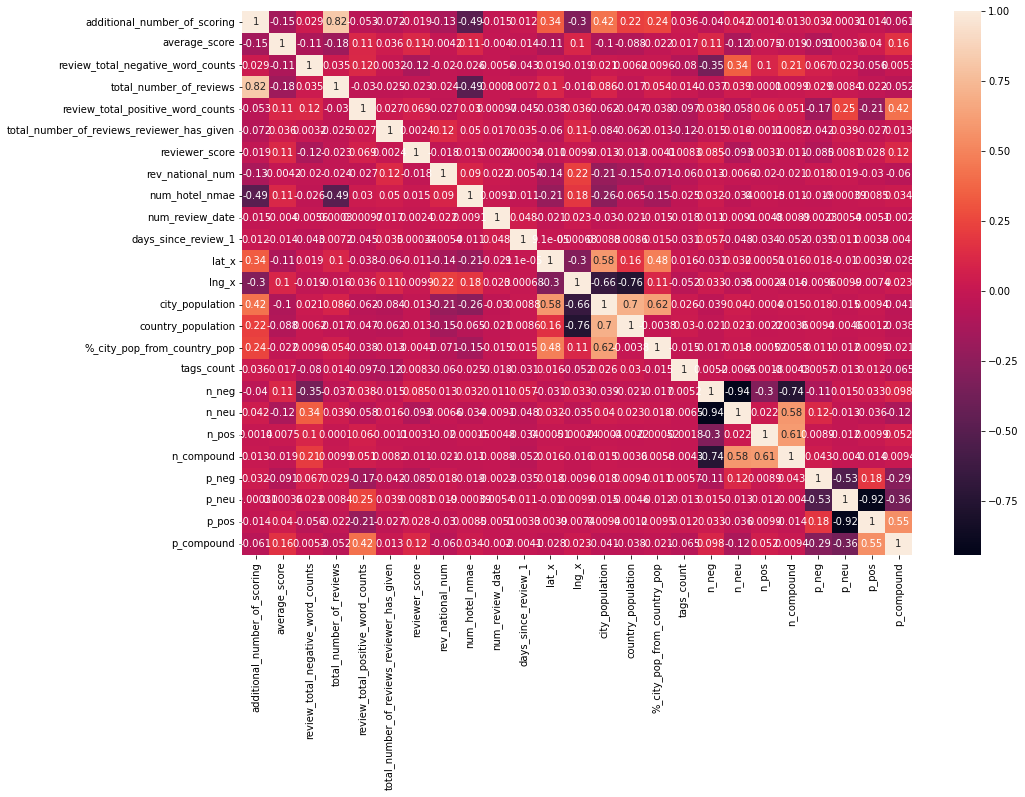

In [30]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['sample'], axis=1).corr(), annot=True)

In [31]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   rev_national_num                            515738 non-null  int64  
 9   num_hotel_nmae                              515738 non-null  int64  
 

In [34]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [35]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [36]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 25), (386803, 25), (386803, 24), (309442, 24), (77361, 24))

**Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.**

In [37]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 
            'review_total_negative_word_counts',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given',
           'days_since_review_1',
           'tags_count',
           'n_neg',
           'n_pos',
           'p_neg',
            'p_pos',
            'p_compound']

# категориальные признаки
cat_cols = ['average_score', 
            'lat_x', 
            'rev_national_num',
            'num_hotel_nmae',
            'num_review_date',
            'сity_population',
           'country_population',
           '%_city_pop_from_country_pop']

<AxesSubplot:>

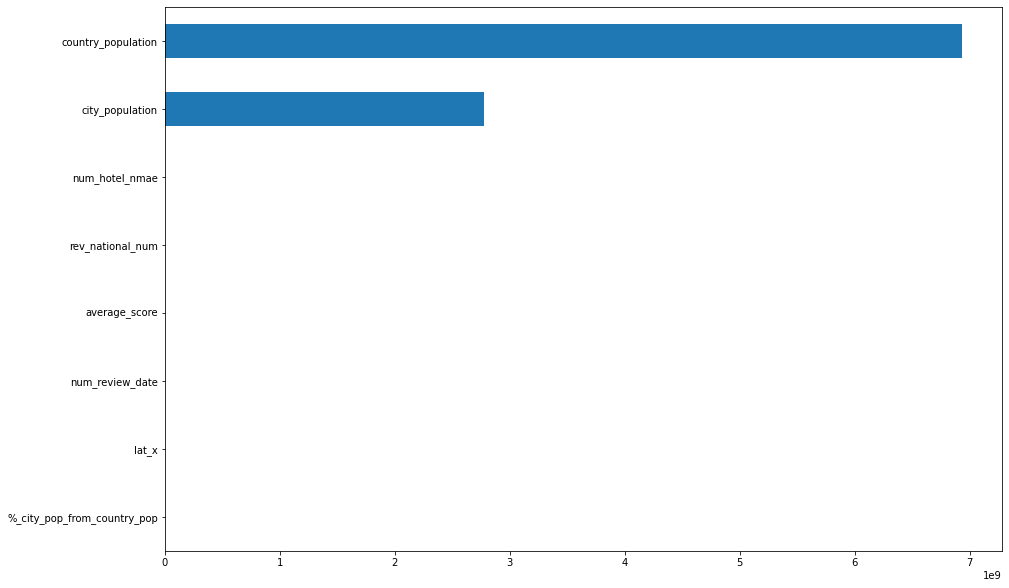

In [38]:
y=y.astype('int')


from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

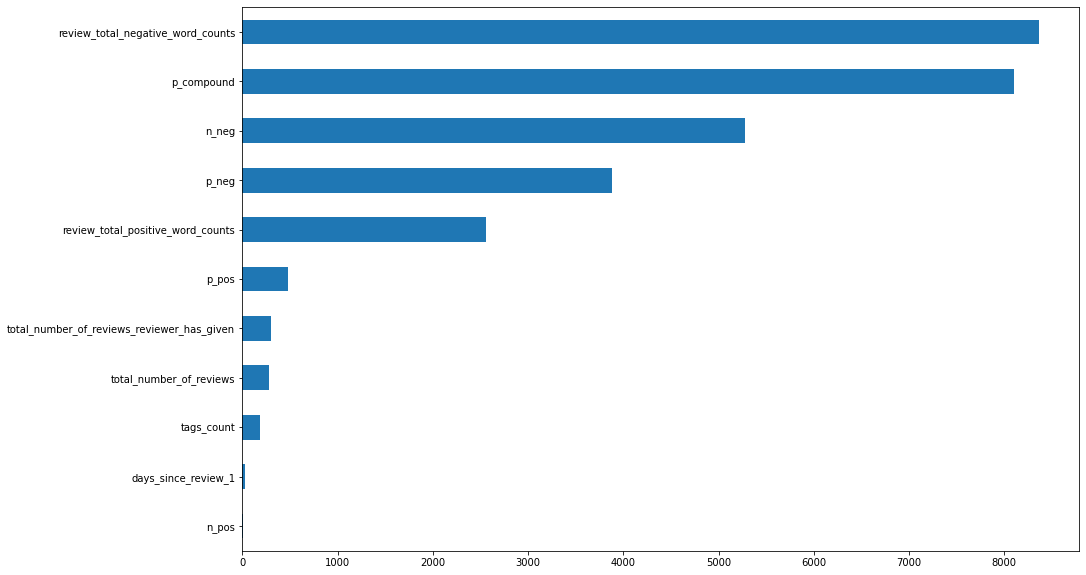

In [39]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [40]:
# поиск мультиколлениарности
pivot = df.corr()
#pivot = pivot.drop('sample', axis=0)
#pivot = pivot.drop('sample', axis=1)

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.7 or x == 1) else x)
    
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis=1)

<AxesSubplot:>

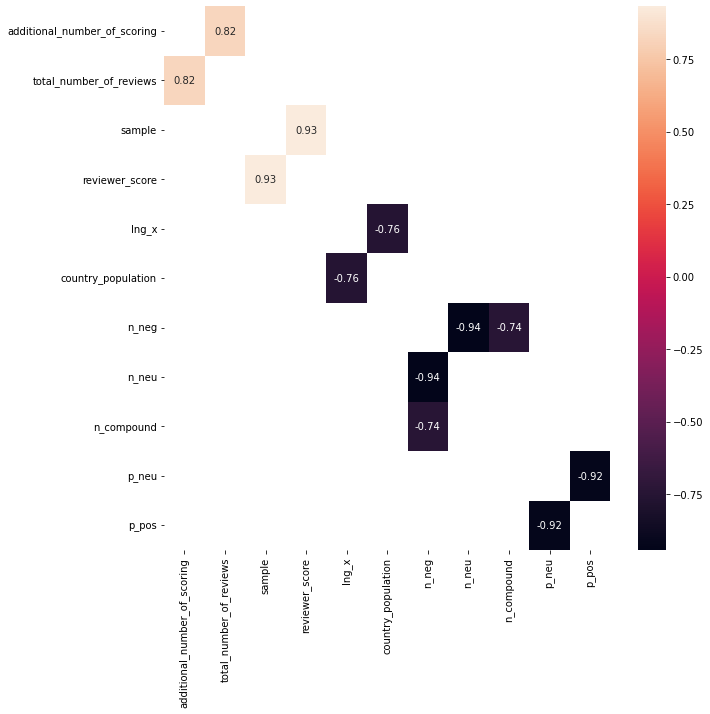

In [41]:
import collections
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(pivot, annot=True)

колинеарные признаки удалять не буду, так как при обучение модели без этих признаков МАPЕ увеличился на 0.01, я предполагаю что это ложная колинеарность как количество убийств и продажи мороженного в примере на платформе

<AxesSubplot:>

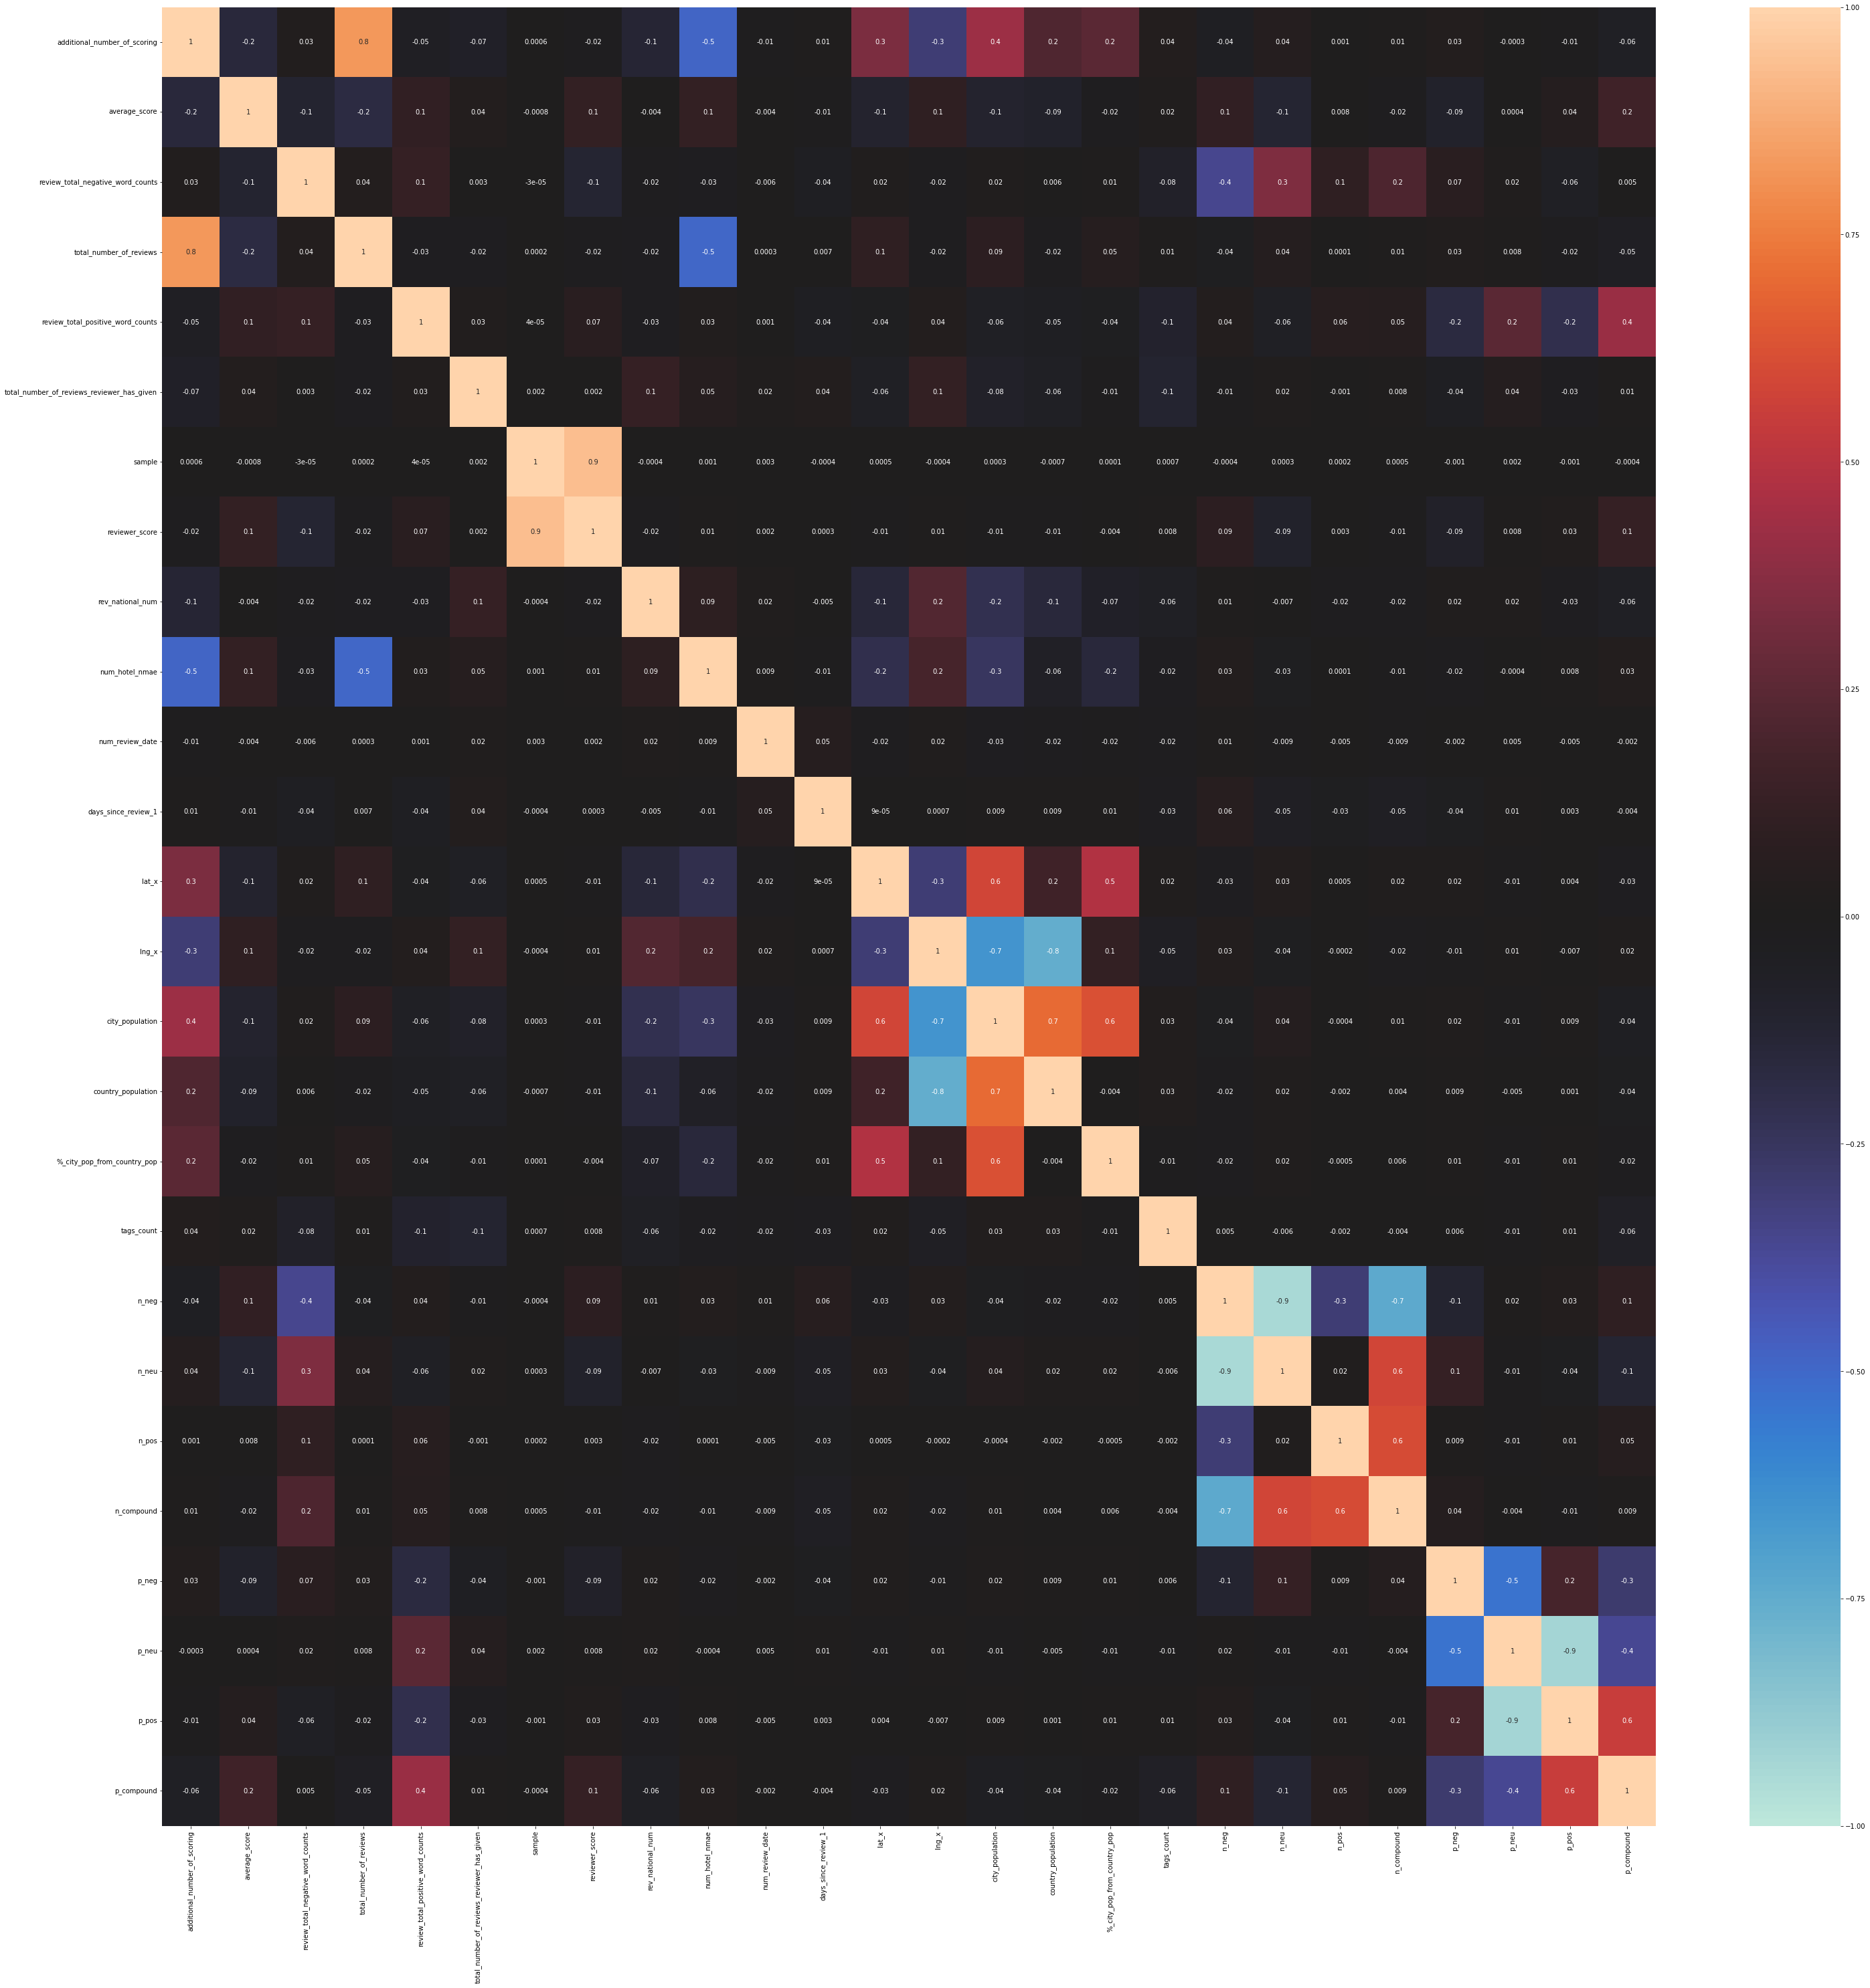

In [42]:
plt.rcParams['figure.figsize'] = (50,50)
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center= 0, fmt='.1g')

In [43]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [50]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [51]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [52]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8800620761907221
MAPE: 12.565864781876373


<AxesSubplot:>

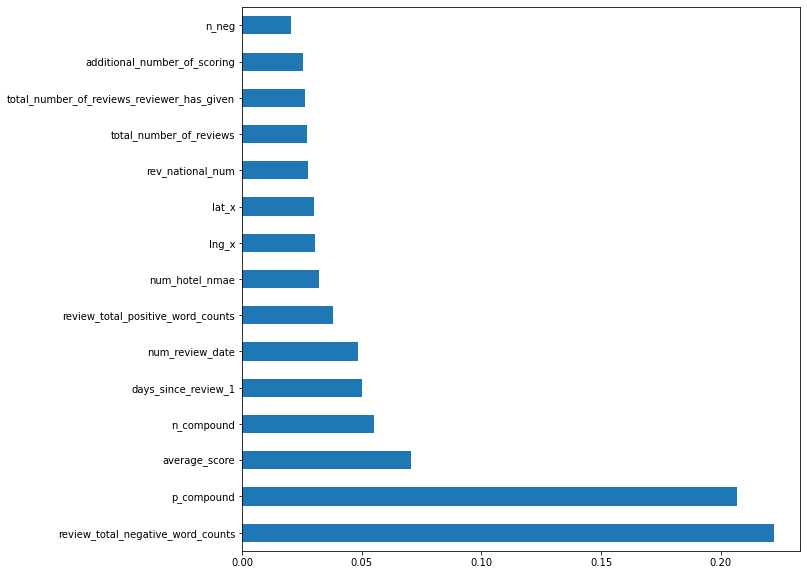

In [53]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [54]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,rev_national_num,num_hotel_nmae,num_review_date,...,%_city_pop_from_country_pop,tags_count,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound
104609,117,8.3,47,694,79,1,0.0,55,835,96,...,0.033052,5,0.089,0.791,0.120,0.3612,0.000,0.703,0.297,0.9815
58233,95,8.2,0,564,14,5,0.0,1,1250,143,...,0.047781,4,1.000,0.000,0.000,-0.7096,0.000,0.466,0.534,0.8834
126855,353,8.1,0,1411,16,3,0.0,1,701,590,...,0.131459,5,1.000,0.000,0.000,-0.7096,0.000,1.000,0.000,0.0000
79644,73,6.6,37,461,17,1,0.0,1,451,314,...,0.131459,4,0.080,0.920,0.000,-0.4341,0.000,0.462,0.538,0.9153
76653,285,8.7,22,3181,3,1,0.0,20,254,27,...,0.212446,5,0.000,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000
100875,832,9.1,13,4672,7,5,0.0,1,270,432,...,0.131459,4,0.000,0.627,0.373,0.7469,0.000,0.328,0.672,0.8481
110718,74,8.7,25,873,21,2,0.0,12,1013,413,...,0.034984,4,0.000,0.913,0.087,0.2023,0.000,0.628,0.372,0.8586
87651,918,8.4,25,4117,30,47,0.0,1,692,241,...,0.131459,4,0.091,0.909,0.000,-0.2732,0.000,0.512,0.488,0.9590
8603,81,9.0,38,707,30,1,0.0,4,827,53,...,0.033052,5,0.000,0.827,0.173,0.7050,0.000,0.682,0.318,0.8934
17319,174,8.8,9,2464,46,34,0.0,23,421,537,...,0.212446,4,0.268,0.732,0.000,-0.2960,0.029,0.766,0.205,0.8588


In [55]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [56]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [57]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


In [58]:
predict_submission

array([8.518, 7.758, 8.682, ..., 8.408, 9.62 , 7.001])

In [59]:
list(sample_submission)

['reviewer_score', 'id']

In [60]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.518,488440
1,7.758,274649
2,8.682,374688
3,9.650,404352
4,9.449,451596
5,8.492,302161
6,7.812,317079
7,7.531,13963
8,8.255,159785
9,7.180,195089
